## Машинное обучение, ШАД.
## Домашнее задание 7: Случайный лес
----

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import copy

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error 
import random
from typing import Callable, Optional, Dict, Any, Sequence
from sklearn.ensemble import RandomForestClassifier, BaggingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
# допиши необходимые импорты

sns.set_theme(palette="Set2", font_scale=1.2)

### Ссылки на использование ИИ

Если при решении задач использовался ИИ, укажи здесь публичные ссылки на все чаты с ИИ и поясни, для каких целей он применялся. Обрати внимание на <a href="https://thetahat.ru/courses/ai-rules">правила</a>.

**Задача 1**
1. ссылка
    - для чего использована
    - для чего использована
2. ссылка
    - для чего использована

**Задача 2**
1. ссылка
    - для чего использована


---
### Задача 0

См. контест

---
### Задача 1

Докажите, что индекс Джини равен вероятности ошибки случайного классификатора, который выдаёт предсказания с вероятностями пропорционально доле классов в выборке.

Обозначим выборку как $(X, y),$ долю класса $k$ в выборке как $p_{k}$

Индекс Джини равен
$$
H(X) = \sum\limits_{k=1}^{K} p_{k}(1-p_{k}) = 1 - \sum\limits_{k=1}^{K}p_{k}^{2}
$$

MSE между $(c_{1}, \ldots , c_{K})$ и one-hot векторами классов:
$$
L(y, c) = \sum\limits_{k=1}^{K}([y=k]-c_{k})^2
$$

Веротность ошибки классификатора, выдающего предсказания с вероятностями пророрциональнол доле классов в выборке
$$
\frac{1}{|X|} \sum\limits_{x_{i}\in X}L(y_{i}, p) = \frac{1}{|X|}\sum\limits_{x_{i}\in X}\sum\limits_{k=1}^{K}([y_{i} = k] - p_{k})^2 = \frac{1}{|X|}\sum\limits_{x_{i}\in X}\sum\limits_{k=1}^{K}\left([y_{i} = k] - 2[y_{i} = k]p_{k} + p_{k}^{2}\right) =
$$
$$
= \frac{1}{|X|}\sum\limits_{x_{i}\in X}\sum\limits_{k=1}^{K} [y_{i} = k] - 2\frac{1}{|X|}\sum\limits_{x_{i}\in X}\sum\limits_{k=1}^{K}[y_{i} = k]p_{k} +  \frac{1}{|X|}\sum\limits_{x_{i}\in X}\sum\limits_{k=1}^{K} p_{k}^2 =
$$
$$
=1 + \sum\limits_{k=1}^{K}p_{k}^{2} -2 \sum\limits_{k=1}^{K}p_{k}\frac{1}{|X|}\sum\limits_{x_{i} \in X}[y_{i} = k] = 1 + \sum\limits_{k=1}^{K}p_{k}^{2} - 2\sum\limits_{k=1}^{K}p_{k}^{2} = 1 - \sum\limits_{k=1}^{K}p_{k}^{2} = H(X)
$$

---
### Задача 2

В этой задаче вам предлагается исследовать зависимость качества предсказаний модели случайного леса в зависимости от различных гиперпараметров на примере задаче регрессии. Будем использовать класс `RandomForestRegressor` библиотеки `sklearn`.

В качестве данных возьмем датасет [**California Housing Prices**](https://www.kaggle.com/datasets/camnugent/california-housing-prices), мы уже начинали работать с ним на семинаре, продолжим его исследовать. Он содержит данные о стоимости жилья в Калифорнии. Датасет состоит из 20640 записей и содержит следующие признаки для каждого округа:

1. **Median Income** — медианный доход жителей района (в десятках тысяч долларов)
2. **Housing Median Age** — медианный возраст жилых домов (в годах)
3. **Total Rooms** — общее количество комнат
4. **Total Bedrooms** — общее количество спален
5. **Population** — численность населения района
6. **Households** — количество домохозяйств
7. **Latitude** — географическая широта
8. **Longitude** — географическая долгота
9. **Ocean proximity** — близость к океану или морю

Целевая переменная — `Median House Value` (медианная стоимость дома в районе), измеряемая в долларах США.

Наша задача будет в предсказании `Median House Value` — медианной стоимости домов в районе.

*Совет.* При отладке кода используйте небольшую часть данных. Финальные вычисления проведите на полных данных. Для оценки времени работы используйте `tqdm` в циклах.

In [5]:
import kagglehub

# Скачиваем датасет из kaggle
path = kagglehub.dataset_download("camnugent/california-housing-prices")
data = pd.read_csv(os.path.join(path, "housing.csv"))
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
# Удаляем пропуски
data = data[~data.isna().any(axis=1)]

# Уникальные значения признака ocean_proximity
data["ocean_proximity"].unique()

ocean_proximity_values = ["ISLAND", "NEAR OCEAN", "NEAR BAY", "<1H OCEAN", "INLAND"]
data["ocean_proximity_num"] = data["ocean_proximity"].apply(
    lambda value: ocean_proximity_values.index(value)
)

In [7]:
data = data.sample(n=1000, random_state=42).reset_index(drop=True)

Разбейте данные на train и test, выделив на test 25% данных.

In [8]:
houses_X = data.drop(columns=["median_house_value", "ocean_proximity"])
houses_y = data["median_house_value"]
X_train, X_test, y_train, y_test = train_test_split(
    houses_X, houses_y, test_size=0.2, random_state=42
)

**1.** Обучите случайный лес с параметрами по умолчанию и выведите MSE на тестовой выборке. Проведите эксперимент 3 раза. Почему результаты отличаются? Какие источники случайности есть при построении случайного леса и какие из них реализуются в данном случае?

In [22]:
for i in range(3):
    defolt_random_forest = RandomForestRegressor()
    defolt_random_forest.fit(X_train, y_train)
    y_pred = defolt_random_forest.predict(X_test)
    mse_for_defolt_random_forest = mean_squared_error(y_test, y_pred)
    print(
        f"Default RandomForestRegressor {i+1} "
        f"Test MSE: {mse_for_defolt_random_forest:.4f}"
    )

Default RandomForestRegressor 1 Test MSE: 4265748475.3121
Default RandomForestRegressor 2 Test MSE: 4454832957.2441
Default RandomForestRegressor 3 Test MSE: 4513568757.0924


**Ответ:** Потому что мы внутри случайного леса мы сэмплируем бутстрэп-выборки на основе эмпирического распределения и на их обучаем деревья.

**2.** Посмотрите, как изменяется качество леса в зависимости от выбранных параметров. Для этого постройте графики зависимости MSE на тестовой выборке от количества деревьев (от 1 до 100) и от максимальной глубины дерева (от 3 до 25). Когда варьируете один из параметров, в качестве другого берите значение по умолчанию.

Попробуйте получить зависимость от количества деревьев, обучив лишь **один случайный лес**. В этом вам поможет аттрибут `_estimators` у обученной модели. Последовательно вызывайте `predict` у каждого дерева и усредняйте полученные результаты.

In [12]:

def cum_metric(
    model: RandomForestRegressor,
    metric: Callable[[np.ndarray, np.ndarray], float],
    x_test: np.ndarray,
    y_test: np.ndarray,
    shuffle: bool = False,
    binary_ths: float = 0.5,
):
    """
    Считает значения метрики metric в зависимости от количества деревьев
    в обученной модели model метом композиции деревьев.

    Параметры:
    model (RandomForestRegressor): модель RandomForest
    metric (Callable[[np.ndarray, np.ndarray], float]): метрика
    x_test (np.ndarray): тестовая выборка
    y_test (np.ndarray): ответы на тестовой выборке
    shuffle (bool): надо ли перемешивать деревья
    binary_ths (float): порог вероятности для истинного класса
                       в случае задачи классификации

    Возвращает: кумулятивные значения метрики
    """

    # Поведение для классификатора и регрессии будет немного отличаться
    is_classifier = isinstance(model, RandomForestClassifier)

    # Считаем предсказания по каждому дереву отдельно
    predictions_by_estimators = [
        est.predict_proba(x_test)[:, 1] if is_classifier else est.predict(x_test)
        for est in model.estimators_
    ]

    if shuffle:
        random.shuffle(predictions_by_estimators)

    numerator = np.cumsum(predictions_by_estimators, axis=0)
    n = len(predictions_by_estimators)
    denominator = (np.arange(n) + 1)[:, np.newaxis]
    cumpred = numerator / denominator

    if is_classifier:
        cumpred = cumpred > binary_ths

    cumacc = [metric(y_test, pred) for pred in cumpred]
    return np.array(cumacc)


def plot_some_lines(
    lines: Dict[str, np.ndarray],
    xlabel: str,
    estrimator_range: Optional[np.ndarray] = None,
    title: Optional[str] = None,
    metric_name: str = "MSE",
):
    """
    Отрисовывает линии из словаря lines

    Параметры:
    lines (Dict[str, np.ndarray]): словарь линий, ключ - label, значение - линия
    xlabel (str): название оси X
    estrimator_range (np.ndarray): значения на оси X
    metric_name (Optional[str]): имя метрики
    title (str): заголовок графика
    """

    with sns.axes_style("darkgrid"):
        plt.figure(figsize=(9, 4))
        plt.title(title)

        for name, line in lines.items():
            if estrimator_range is not None:
                plt.plot(estrimator_range, line, label=name, lw=3)
            else:
                plt.plot(line, label=name, lw=3)
        plt.xlabel(xlabel)
        plt.ylabel(f"Метрика {metric_name}")
        plt.legend()
        plt.show()


In [14]:
def get_test_mse(
    param_name: str, grid: Sequence[Any], other_params_dict: Dict[str, Any] = {}
):
    """
    Функция для оценки точности классификации
    для заданных значений параметра param_name

    Параметры:
    param_name (str): название параметра, который собираемся варьировать
    grid (Sequence[Any]): сетка значений параметра
    other_params_dict (Dict[str, Any]): словарь со значениями остальных параметров
    """

    test_mse = []
    params_dict = copy.copy(other_params_dict)

    for param_value in tqdm(grid):
        params_dict.update({param_name: param_value})
        estimator = RandomForestRegressor(**params_dict, random_state=42, n_jobs=-1)
        estimator.fit(X_train, y_train)

        test_mse.append(mean_squared_error(y_test, estimator.predict(X_test)))

    return test_mse


def plot_dependence(
    param_name: str, grid: Sequence[Any] = range(2, 20), other_params_dict: Dict[str, Any] = {}
):
    """
    Функция для отображения графика зависимости MSE
    от значения параметра c названием param_name

    Параметры:
    param_name (str): название параметра, который собираемся варьировать
    grid (Sequence[Any]): сетка значений параметра
    other_params_dict (Dict[str, Any]): словарь со значениями остальных параметров
    """

    test_mse = get_test_mse(
        param_name, grid, other_params_dict
    )

    plot_some_lines(
        lines={"RandomForestRegressor": test_mse},
        xlabel=param_name,
        estrimator_range=grid,
        title=f"Зависимость MSE от {param_name}",
        metric_name="MSE",
    )

In [28]:
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


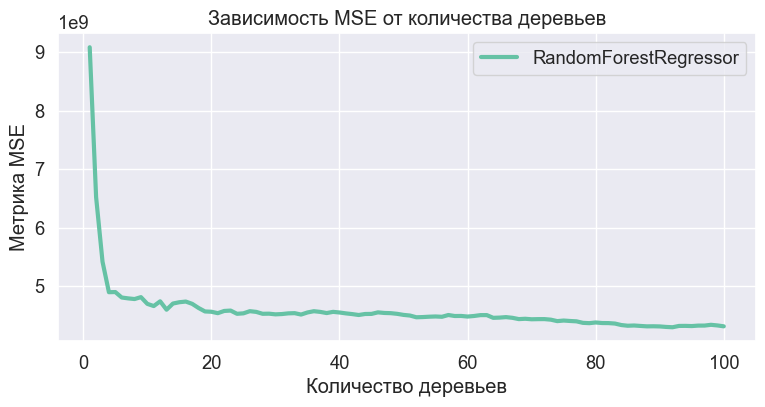

In [30]:
cum_mse = cum_metric(model=random_forest, metric=mean_squared_error, x_test=X_test.to_numpy(), y_test=y_test.to_numpy())
estrimator_range = np.arange(random_forest.n_estimators) + 1

plot_some_lines(
    lines={"RandomForestRegressor": cum_mse},
    xlabel="Количество деревьев",
    estrimator_range=estrimator_range,
    title="Зависимость MSE от количества деревьев",
    metric_name="MSE"
)

100%|██████████| 23/23 [00:02<00:00, 11.25it/s]


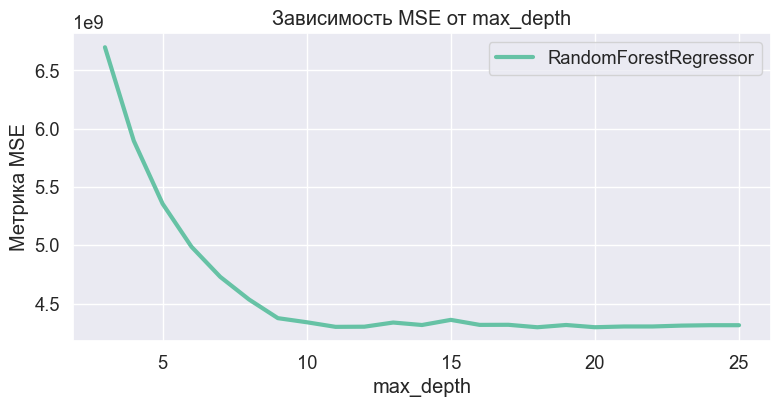

In [43]:
plot_dependence(
    param_name="max_depth",
    grid=range(3, 26)
)

Основываясь на полученных графиках, ответьте на следующие вопросы.

1. Какие закономерности можно увидеть на построенных графиках? Почему графики получились такими?

2. Как изменяется качество предсказаний с увеличением исследуемых параметров, когда эти параметры уже достаточно большие.

3. В предыдущем задании вы на практике убедились, что решающее дерево начинает переобучаться при достаточно больших значениях максимальной глубины. Справедливо ли это утверждение для случайного леса? Поясните свой ответ, опираясь на своё знание теории.

**Ответ:** 

1.  При увеличении параметров метрика MSE в среднем уменьшается и выходит на некоторое плато. Незначительно ухудшается из-за начала переобучения отдельных деревьев или случайности.

2.  Когда количество деревьев достаточно много, то дальнейшее увеличение практически не улучшает MSE. При больших значениях глубины MSE не изменяется или незначительно ухудшается из-за начала переобучения отдельных деревьев.

3. Переобучение происходит на отдельных деревьях, а т.к. случайный лес усредняет предсказания, поэтому переобучение наступает медленнее. Конечно, если переобучаться почти все отдельные деревья, то случайный лес тоже переобучиться, но получиться такой исход очень сложно.

**3.** Исследуйте зависимость метрики MSE от максимальной глубины составляющих деревьев `max_depth`. В этом случае придется заново обучать весь лес для каждого следующего значения `max_depth`.

Не забывайте делать пояснения и выводы!

100%|██████████| 23/23 [00:02<00:00, 11.14it/s]


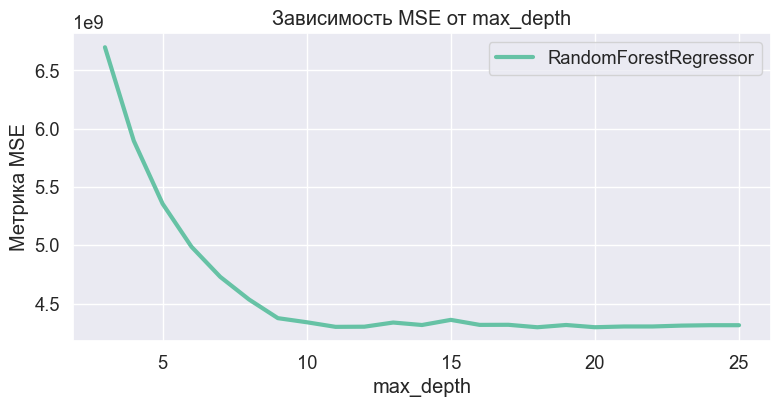

In [44]:
plot_dependence(
    param_name="max_depth",
    grid=range(3, 26)
)

**Ответ:** При увеличении параметров метрика MSE в среднем уменьшается и выходит на некоторое плато. Незначительно ухудшается из-за начала переобучения отдельных деревьев или случайности.

**4.** Исследуйте зависимость метрики MSE от количества признаков, по которым происходит разбиение в вершине дерева. Поскольку количество признаков в датасете не очень большое (их 8), то можно перебрать все возможные варианты количества признаков, использующихся при разбиении вершин.

Не забывайте делать пояснения и выводы!

In [15]:
def get_train_test_mse(
    param_name: str, grid: Sequence[Any], other_params_dict: Dict[str, Any] = {}
):
    """
    Функция для оценки точности классификации
    для заданных значений параметра param_name

    Параметры:
    param_name (str): название параметра, который собираемся варьировать
    grid (Sequence[Any]): сетка значений параметра
    other_params_dict (Dict[str, Any]): словарь со значениями остальных параметров
    """

    test_mse = []
    train_mse = []
    params_dict = copy.copy(other_params_dict)

    for param_value in tqdm(grid):
        params_dict.update({param_name: param_value})
        estimator = RandomForestRegressor(**params_dict, random_state=42, n_jobs=-1)
        estimator.fit(X_train, y_train)

        train_mse.append(mean_squared_error(y_train, estimator.predict(X_train)))
        test_mse.append(mean_squared_error(y_test, estimator.predict(X_test)))

    return train_mse, test_mse


def plot_dependence_train_test(
    param_name: str, grid: Sequence[Any] = range(2, 20), other_params_dict: Dict[str, Any] = {}
):
    """
    Функция для отображения графика зависимости MSE
    от значения параметра c названием param_name

    Параметры:
    param_name (str): название параметра, который собираемся варьировать
    grid (Sequence[Any]): сетка значений параметра
    other_params_dict (Dict[str, Any]): словарь со значениями остальных параметров
    """

    train_mse, test_mse = get_train_test_mse(
        param_name, grid, other_params_dict
    )

    plot_some_lines(
        lines={
            "Train": train_mse,
            "Test": test_mse
            },
        xlabel=param_name,
        estrimator_range=grid,
        title=f"Зависимость MSE от {param_name}",
        metric_name="MSE",
    )

Постройте график зависимости метрики MSE на `test` и `train` в зависимости от числа признаков, использующихся при разбиении в каждой вершине.

100%|██████████| 8/8 [00:00<00:00,  9.43it/s]


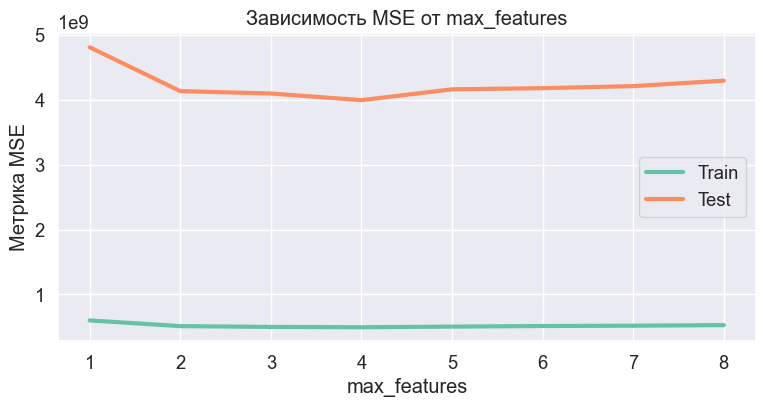

In [13]:
plot_dependence_train_test(
    param_name="max_features",
    grid=range(1, houses_X.shape[1])
)

Почему график получился таким? Как зависит разнообразие деревьев, инными словами их скоррелированность, от величины `n_features`?

**Ответ:** При малом количестве фичей отдельные деревья слишком слабые. При средним количсетве фичей отдельные деревья достаточно хорошо предстазывают, при этом они разнообразны. При большом количестве фичей деревья становяться очень похожими, т.е. сильно скоррелированными.

**5.** Проведите эксперимент, в котором выясните, как изменится качество регрессии, если набор признаков, по которым происходит разбиение в каждой вершине определяется не заново в каждой вершине, а задан заранее для всего дерева. То есть перед каждым построением дерева выбирается новый набор признаков, который будет рассматриваться при построении всех разбиений в этом дереве.

Для реализации данного эксперимента используйте класс беггинг-модели `sklearn.ensemble.BaggingRegressor`, у которого используйте следующие поля:
* `base_estimator` — базовая модель, используйте `sklearn.tree.DecisionTreeRegressor`;
* `max_features` — количество признаков для каждой базовой модели;
* `n_estimators` — количество базовых моделей.

Постройте графики MSE на обучающей и на валидационной выборке в зависимости от числа рассматриваемых признаков в дереве.

100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


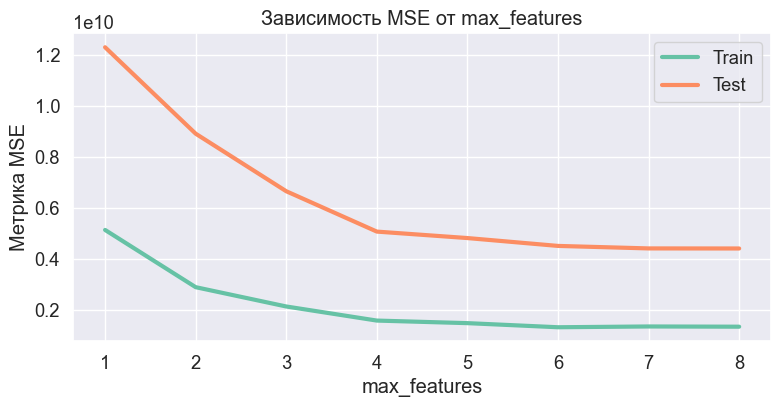

In [17]:
def get_train_test_mse(
    param_name: str, grid: Sequence[Any], other_params_dict: Dict[str, Any] = {}
):
    """
    Функция для оценки точности классификации
    для заданных значений параметра param_name

    Параметры:
    param_name (str): название параметра, который собираемся варьировать
    grid (Sequence[Any]): сетка значений параметра
    other_params_dict (Dict[str, Any]): словарь со значениями остальных параметров
    """

    test_mse = []
    train_mse = []
    params_dict = copy.copy(other_params_dict)

    for param_value in tqdm(grid):
        params_dict.update({param_name: param_value})
        estimator = BaggingRegressor(**params_dict, random_state=42, n_jobs=-1)
        estimator.fit(X_train, y_train)

        train_mse.append(mean_squared_error(y_train, estimator.predict(X_train)))
        test_mse.append(mean_squared_error(y_test, estimator.predict(X_test)))

    return train_mse, test_mse


def plot_dependence_train_test(
    param_name: str, grid: Sequence[Any] = range(2, 20), other_params_dict: Dict[str, Any] = {}
):
    """
    Функция для отображения графика зависимости MSE
    от значения параметра c названием param_name

    Параметры:
    param_name (str): название параметра, который собираемся варьировать
    grid (Sequence[Any]): сетка значений параметра
    other_params_dict (Dict[str, Any]): словарь со значениями остальных параметров
    """

    train_mse, test_mse = get_train_test_mse(
        param_name, grid, other_params_dict
    )

    plot_some_lines(
        lines={
            "Train": train_mse,
            "Test": test_mse
            },
        xlabel=param_name,
        estrimator_range=grid,
        title=f"Зависимость MSE от {param_name}",
        metric_name="MSE",
    )

plot_dependence_train_test(
    param_name="max_features",
    grid=range(1, houses_X.shape[1]),
    other_params_dict={ 'estimator': RandomForestRegressor(random_state=42) }
)

Сравните результаты обычного случайного леса с только что построенным лесом.

Сделайте выводы. Объясните, чем плох такой подход пострения случайного леса. Какое преимущество мы получаем, когда выбираем случайное подмножество признаков в каждой вершине в обычном случайном лесу? Опирайтесь в своих рассуждениях на bias-variance разложение.

**Ответ:** Глобальное задание признаков для деревьев справилось хуже. Отдельные деревья могут оказаться недостаточно сильными, если выбереться "плохой" набор признаков, в тернинах bias-variance разложения мы увеличим bais. Нужно будет больше деревьев, чтобы покрыть подмножества признаков. Когда мы выбираем подмножество признаков локально, то тем самым уменьшаем bais, т.е. лучше улавливаем какие-то зависимости.

Поясните разницу между следующими конструкциями:

`BaggingRegressor(base_estimator=DecisionTreeRegressor(), max_features=n_features)`

`BaggingRegressor(base_estimator=DecisionTreeRegressor(max_features=n_features))`

**Ответ:** В первом случаи мы max_features влият на бустрап-выборки, а, значит, задает максимальное количество признаков, на котором будут обучаться дерево глобально.

Во втором случаи это параметр влияющий на количество выбираемых признаков локально в каждой вершине дерева.

**6.** Как мы знаем, модели на основе решающих деревьев могут плохо работать при наличии линейных зависимостей. Давайте рассмотрим композицию линейной регрессии и случайного леса.

1. Обучите по данным линейную модель с регуляризацией, не забывайте про стандартизацию признаков.
2. Посчитайте остатки линейной модели как разность истинного таргета и предсказания.
3. Обучите случайный лес предсказывать эти остатки по исходным признакам.

Оцените качество такой модели на обучающей и тестовой выборках и сравните с предыдущими.

In [10]:
ridge_pipeline = Pipeline(
    [
        (
            'fill missing values',
            SimpleImputer(strategy='mean')
        ),
        (
            'normalize features',
            StandardScaler()
        ),
        (
            'estimator',
            Ridge(max_iter=10000, random_state=42)
        )
    ]
)

In [12]:
ridge_pipeline.fit(X_train, y_train)


,steps,"[('fill missing values', ...), ('normalize features', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'mean'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [15]:
y_pred_train = ridge_pipeline.predict(X_train)
y_test_pred = ridge_pipeline.predict(X_test)
mse_for_ridge_train = mean_squared_error(y_train, y_pred_train)
mse_for_ridge_test = mean_squared_error(y_test, y_pred)

print(f"Ridge Train MSE: {mse_for_ridge_train:.4f}")
print(f"Ridge Test MSE: {mse_for_ridge_test:.4f}")

Ridge Train MSE: 4572880016.1789
Ridge Test MSE: 5446731509.8690


In [17]:
tailes_y_train = y_train - y_pred_train
tailes_y_test = y_test - y_test_pred

random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train, tailes_y_train)

tailes_y_pred_train_rf = random_forest.predict(X_train)
mse_for_rf_train = mean_squared_error(tailes_y_train, tailes_y_pred_train_rf)
tailes_y_pred_test_rf = random_forest.predict(X_test)
mse_for_rf_test = mean_squared_error(tailes_y_test, tailes_y_pred_test_rf)

print(f"RandomForest on tailes Train MSE: {mse_for_rf_train:.4f}")
print(f"RandomForest on tailes Test MSE: {mse_for_rf_test:.4f}")

RandomForest on tailes Train MSE: 484137906.0459
RandomForest on tailes Test MSE: 3064153747.9209


В таком подходе появляется фактор переобучения. Поясните, в чем он заключается. Подумайте, как можно было бы от него избавиться (достаточно каких-либо размышлений).

**Ответ:** <...>

**7.** Сделайте общий вывод по задаче.

**Вывод:** 

---
© 2025 команда <a href="https://thetahat.ru/">ThetaHat</a> для курса ML-1 ШАД